*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Text Classification of MultiNLI Sentences using XLNet
**XLNet: Generalized Autoregressive Pretraining for Language Understanding** [\[1\]](#References)

# Table of Contents
1. [Introduction](#1.-Introduction)
    * 1.1. What is XLNet?
    * 1.2. How to use XLNet for Text Classification?
2. [Getting Started](#2.-Getting-Started)  
    * 2.1. Import Modules
    * 2.2. Define Variables and Hyperparameters
    * 2.3. Load Dataset
3. [Preprocessing Data](#3.-Preprocessing-Data)
    * 3.1 Splitting Data
    * 3.2. Tokenizing and Preprocess
4. [Model Training](#4.-Model-Training)
    * 4.1 Create Model
    * 4.2 Train Model
    * 4.3 MLflow for train-validation loss plot
5. [Evaluation](#5.-Evaluation)
    * 5.1 Predict
    * 5.2 Report Classification Metrics
    * 5.3 Confusion Matrix
6. [References](#References)

## 1. Introduction
------------------
In this notebook, we fine-tune and evaluate a pretrained [XLNet](https://arxiv.org/abs/1906.08237) model on a subset of the [MultiNLI](https://www.nyu.edu/projects/bowman/multinli/) dataset.

We use a [sequence classifier](../../utils_nlp/xlnet/sequence_classification.py) that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/pytorch-transformers) of CMU and Google's [XLNet](https://github.com/zihangdai/xlnet).

### 1.1. What is XLNet?

[XLNet](https://arxiv.org/pdf/1906.08237.pdf) is a generalized autoregressive pretraining method incorporating 3 ideas:
1. maximum expected likelihood over all permutations of the factorization order that enables learning bidirectional context  
<img src="https://i.imgur.com/1xeOp4Y.png" width="1000">
2. autoregressive formulation that overcomes the limitations of BERT [\[2\]](#References)  
<img src="https://i.imgur.com/eQrAvVj.png" width="1000">
3. relative positional embeddings and recurrence mechanism from Transformer XL [\[3\]](#References)

### 1.2. How to use XLNet for Text Classification?

Using a pre-trained XLNet model, we can fine-tune the model for text classification by training it on the MNLI dataset [\[4\]](#References). The Multi-Genre Natural Language Inference (MultiNLI) corpus is a crowd-sourced collection of 433k sentence pairs annotated with textual entailment information. 

This notebook contains an end-to-end walkthrough of a pipeline to run PyTorch-Transformer's reimplementation [\[5\]](#References) of the XLNet model.

## 2. Getting Started
--------------
In this section, we will:

1. Import the modules required to run XLNet and this notebook
2. Define and discuss variables and hyperparameters in the XLNet model
3. Load the MNLI dataset using Pandas

### 2.1. Import Modules

Some key modules we will use include:

1. utils_nlp: contains the xlnet model from Hugging Face
2. mlflow: track, log and visualize key metrics in the machine learning process

In [ ]:
%load_ext autoreload
%autoreload 2

In [19]:
import sys
sys.path.append("../../")
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from utils_nlp.dataset.multinli import load_pandas_df
from utils_nlp.eval.classification import eval_classification, plot_confusion_matrix
from utils_nlp.common.timer import Timer
from utils_nlp.models.xlnet.common import Language, Tokenizer
from utils_nlp.models.xlnet.sequence_classification import XLNetSequenceClassifier
from utils_nlp.models.xlnet.common import log_xlnet_params
import mlflow
import datetime

### 2.2. Define Variables and Hyperparameters

**Global Variables:**
- DATA_FOLDER : data downloaded to this folder 
- XLNET_CACHE_DIR : model caches information to this folder 
- LANGUAGE : which pretrained model to use 
- LABEL_COL : column of data containing label 
- TEXT_COL : column of data containing sentence 

**Hyperparmeters:**
- MAX_SEQ_LENGTH : maximum sentence length to pad or truncate examples to 
- WEIGHT_DECAY : regularization on model weights 
- WARMUP_STEPS : number of steps to increase learning rate over at start of training (then decrease learning rate for duration of training) 

**Debug Switch:**
- DEBUG : If True, will train and evaluate model only on a small portion of data 

In [3]:
DATA_FOLDER = "../../../temp"
XLNET_CACHE_DIR="../../../temp"
LANGUAGE = Language.ENGLISHCASED
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 16
NUM_GPUS = 1
NUM_EPOCHS = 1
TRAIN_SIZE = 0.6
VAL_SIZE = 0.1
LABEL_COL = "genre"
TEXT_COL = "sentence1"
WEIGHT_DECAY = 0.0
WARMUP_STEPS = 1000

### Hyperparamters to tune
MAX_SEQ_LENGTH = 128
LEARNING_RATE = 5e-5
ADAM_EPSILON = 1e-8

DEBUG = False
LOGGING_STEPS = 10
SAVE_STEPS = 100
VAL_STEPS = 100
mlflow.start_run(run_name = datetime.datetime.now())
log_xlnet_params(locals())

### 2.3. Load Dataset
We start by loading a subset of the data. The following function also downloads and extracts the files, if they don't exist in the data folder.

The MultiNLI dataset is mainly used for natural language inference (NLI) tasks, where the inputs are sentence pairs and the labels are entailment indicators. The sentence pairs are also classified into *genres* that allow for more coverage and better evaluation of NLI models.

For our classification task, we use the first sentence only as the text input, and the corresponding genre as the label. We select the examples corresponding to one of the entailment labels (*neutral* in this case) to avoid duplicate rows, as the sentences are not unique, whereas the sentence pairs are.

In [4]:
df = load_pandas_df(DATA_FOLDER, "train")
df = df[df["gold_label"]=="neutral"]  # get unique sentences

if DEBUG:
    inds = random.sample(range(len(df.index)), 10000)
    df = df.iloc[inds]

In [5]:
df.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],government,neutral,31193n,31193,Conceptually cream skimming has two basic dime...,( ( Conceptually ( cream skimming ) ) ( ( has ...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,Product and geography are what make cream skim...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...
4,[neutral],telephone,neutral,50563n,50563,yeah i tell you what though if you go price so...,( yeah ( i ( ( tell you ) ( what ( ( though ( ...,(ROOT (S (VP (VB yeah) (S (NP (FW i)) (VP (VB ...,The tennis shoes have a range of prices.,( ( The ( tennis shoes ) ) ( ( have ( ( a rang...,(ROOT (S (NP (DT The) (NN tennis) (NNS shoes))...
6,[neutral],travel,neutral,42487n,42487,But a few Christian mosaics survive above the ...,( But ( ( a ( few ( Christian mosaics ) ) ) ( ...,(ROOT (S (CC But) (NP (DT a) (JJ few) (JJ Chri...,Most of the Christian mosaics were destroyed b...,( ( Most ( of ( the ( Christian mosaics ) ) ) ...,(ROOT (S (NP (NP (JJS Most)) (PP (IN of) (NP (...
12,[neutral],slate,neutral,32819n,32819,It's not that the questions they asked weren't...,( It ( ( ( ( 's not ) ( that ( ( ( the questio...,(ROOT (S (NP (PRP It)) (VP (VBZ 's) (RB not) (...,All of the questions were interesting accordin...,( ( All ( of ( the questions ) ) ) ( ( ( were ...,(ROOT (S (NP (NP (DT All)) (PP (IN of) (NP (DT...
13,[neutral],travel,neutral,52772n,52772,"Thebes held onto power until the 12th Dynasty,...",( Thebes ( ( ( ( ( held ( onto power ) ) ( unt...,(ROOT (S (NP (NNS Thebes)) (VP (VBD held) (PP ...,The capital near Memphis lasted only half a ce...,( ( ( The capital ) ( near Memphis ) ) ( ( ( (...,(ROOT (S (NP (NP (DT The) (NN capital)) (PP (I...


The examples in the dataset are grouped into 5 genres:

In [6]:
df[LABEL_COL].value_counts()

telephone     27783
government    25784
travel        25783
fiction       25782
slate         25768
Name: genre, dtype: int64

## 3. Preprocessing Data
-------------

### 3.1. Splitting Data
We split the data into 3 parts with the following proportions:
- Train Set 60%
- Validation Set 10%
- Test Set 30%

Then we encode the class labels from categories into integers.

In [7]:
# split
df_trainval, df_test = train_test_split(df, train_size = TRAIN_SIZE + VAL_SIZE, random_state=0)
df_train, df_val = train_test_split(df_trainval, train_size = TRAIN_SIZE / (TRAIN_SIZE + VAL_SIZE), random_state=0)

# encode labels
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(df_train[LABEL_COL])
labels_val = label_encoder.transform(df_val[LABEL_COL])
labels_test = label_encoder.transform(df_test[LABEL_COL])
label_list = label_encoder.classes_

num_labels = len(np.unique(labels_train))

/home/amgupte/anaconda3/envs/nlp_gpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


We check to ensure the label classes are balanced in the train and validation set.

In [8]:
df_train[LABEL_COL].value_counts()

telephone     16586
travel        15507
slate         15497
fiction       15478
government    15472
Name: genre, dtype: int64

In [9]:
df_test[LABEL_COL].value_counts()

telephone     8434
travel        7734
government    7715
fiction       7705
slate         7682
Name: genre, dtype: int64

In [10]:
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_val.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Number of unique labels: 5
Number of training examples: 78540
Number of testing examples: 13090
Number of testing examples: 39270


### 3.2. Tokenize and Preprocess
Before training, we tokenize the text documents and convert them to lists of tokens. The following steps instantiate a XLNet tokenizer given the language, and tokenize the text of the training and testing sets.

We perform the following preprocessing steps in the cell below:
- Convert the tokens into token indices corresponding to the XLNet-base tokenizer's vocabulary
- Add the special tokens [CLS] and [SEP] to mark the end of a sentence
- Pad or truncate the token lists to the specified max length
- Return id lists that indicate which word the tokens map to
- Return mask lists that indicate paddings' positions
- Return segment type id lists that indicates which segment each the tokens belongs to

**See figure below for the step-by-step tokenization process**  
<img src="https://i.imgur.com/o6ewGgd.jpg" width="1000">

*For more information on XLNet's input format, see pytorch-transformer [implementation](https://github.com/huggingface/pytorch-transformers/blob/master/examples/utils_glue.py)*

In [11]:
tokenizer = Tokenizer(LANGUAGE, cache_dir=XLNET_CACHE_DIR)

train_input_ids, train_input_mask, train_segment_ids = tokenizer.preprocess_classification_tokens(list(df_train[TEXT_COL]), MAX_SEQ_LENGTH)
val_input_ids, val_input_mask, val_segment_ids = tokenizer.preprocess_classification_tokens(list(df_val[TEXT_COL]), MAX_SEQ_LENGTH)
test_input_ids, test_input_mask, test_segment_ids = tokenizer.preprocess_classification_tokens(list(df_test[TEXT_COL]), MAX_SEQ_LENGTH)

## 4. Model Training
----------------------------
### 4.1. Create model
First, we create a sequence classifier that loads a pre-trained XLNet model, given the language and number of labels.

In [12]:
classifier = XLNetSequenceClassifier(
    language=LANGUAGE,
    num_labels=num_labels,
    cache_dir=XLNET_CACHE_DIR,
    num_gpus=NUM_GPUS,        
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

### 4.2. Train Model

We train the classifier using the training examples. This involves fine-tuning the XLNet Transformer and learning a linear classification layer on top of that

#### 4.2.1. Machine Specifications

We're using two P4000 GPUs - each with 8GB of memory - to train this model. 

For a combined GPU memory of 16GB and sequence length of 128 tokens, the maximum batch size we could use for training is 32. Without validation, the maximum batch size for training is 56. 

#### 4.2.2. Shuffling of the training set before each epoch 

We shuffle data in the mini-batch training before each epoch to prevent overfitting that occurs when the order of data within every epoch is the same. 

In [13]:
with Timer() as t:
    classifier.fit(
        token_ids=train_input_ids,
        input_mask=train_input_mask,
        token_type_ids=train_segment_ids,
        labels=labels_train,  
        val_token_ids=val_input_ids,
        val_input_mask=val_input_mask,
        val_token_type_ids=val_segment_ids,
        val_labels=labels_val,
        verbose=True,
        logging_steps = LOGGING_STEPS,
        save_steps = SAVE_STEPS,
        val_steps = VAL_STEPS,
    )    
print("[Training time: {:.3f} hrs]".format(t.interval / 3600))

Iteration:   0%|          | 1/4909 [00:00<55:30,  1.47it/s]

epoch:1/1; batch:1->491/4909; average training loss:1.656134


Iteration:  10%|█         | 492/4909 [15:47<47:04,  1.56it/s]

epoch:1/1; batch:492->982/4909; average training loss:0.927851; average val loss:0.716668


Iteration:  20%|██        | 983/4909 [34:12<42:38,  1.53it/s]

epoch:1/1; batch:983->1473/4909; average training loss:0.760149; average val loss:0.540830


Iteration:  30%|███       | 1474/4909 [52:36<36:25,  1.57it/s]

epoch:1/1; batch:1474->1964/4909; average training loss:0.679937; average val loss:0.506850


Iteration:  40%|████      | 1965/4909 [1:10:57<31:46,  1.54it/s]

epoch:1/1; batch:1965->2455/4909; average training loss:0.630495; average val loss:0.489841


Iteration:  50%|█████     | 2456/4909 [1:29:22<26:32,  1.54it/s]

epoch:1/1; batch:2456->2946/4909; average training loss:0.592024; average val loss:0.409858


Iteration:  60%|██████    | 2947/4909 [1:47:46<21:12,  1.54it/s]

epoch:1/1; batch:2947->3437/4909; average training loss:0.562752; average val loss:0.388481


Iteration:  70%|███████   | 3438/4909 [2:06:12<16:04,  1.53it/s]

epoch:1/1; batch:3438->3928/4909; average training loss:0.536014; average val loss:0.362622


Iteration:  80%|████████  | 3929/4909 [2:24:40<10:45,  1.52it/s]

epoch:1/1; batch:3929->4419/4909; average training loss:0.515133; average val loss:0.319612


Iteration:  90%|█████████ | 4420/4909 [2:43:03<05:40,  1.44it/s]

epoch:1/1; batch:4420->4909/4909; average training loss:0.494290; average val loss:0.318628


Iteration: 100%|██████████| 4909/4909 [3:01:23<00:00,  2.22s/it]


[Training time: 3.026 hrs]


### 4.3. MLFlow Train-Validation Loss Plot 

During training, MLflow logs the loss of the training and validation batches and can automatically generate figures of the losses over time. The figure below enables us to visualize the model performance against the number of training iterations.  
<img src="https://i.imgur.com/cyn7XVM.png" width="1000">

## 5. Evaluation
-------------------------
### 5.1. Predict
We score the test set using the trained classifier:

In [14]:
preds = classifier.predict(
    token_ids=test_input_ids,
    input_mask=test_input_mask,
    token_type_ids=test_segment_ids,
    num_gpus=NUM_GPUS,
    batch_size=BATCH_SIZE,
    probabilities=False
)

39280it [07:46, 84.27it/s]                           


### 5.2. Report Classification Metrics
Finally, we compute the accuracy, precision, recall, and F1 metrics of the evaluation on the test set.

In [15]:
cls_report = classification_report(labels_test, preds, target_names=label_encoder.classes_,output_dict=True)
print(classification_report(labels_test, preds, target_names=label_encoder.classes_))

cls_report_df = pd.DataFrame(cls_report)
cls_report_df.to_csv(path_or_buf=os.path.join(os.getcwd(),"checkpoints","cls_report.csv"))
mlflow.log_artifact(os.path.join(os.getcwd(),"checkpoints","cls_report.csv"))
mlflow.end_run()

              precision    recall  f1-score   support

     fiction       0.85      0.89      0.87      7705
  government       0.91      0.90      0.90      7715
       slate       0.78      0.77      0.77      7682
   telephone       0.99      0.99      0.99      8434
      travel       0.91      0.89      0.90      7734

   micro avg       0.89      0.89      0.89     39270
   macro avg       0.89      0.89      0.89     39270
weighted avg       0.89      0.89      0.89     39270



### 5.3. Confusion Matrix
The following confusion matrix - created using the data visualization library 'Seaborn' - allows us to easily identify which classes the model performed better or worse in. 

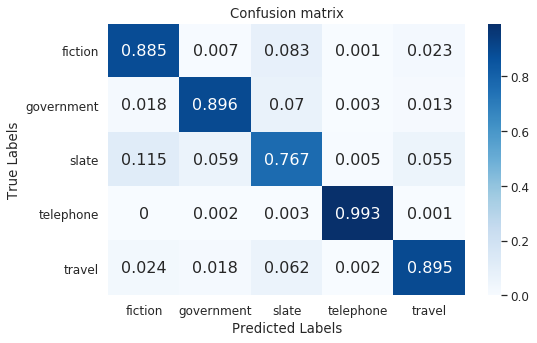

In [26]:
plot_confusion_matrix(labels_test,preds,label_encoder.classes_, normalize=True)

In [27]:
mlflow.end_run()

## References
---------------

1. Yang, Zhilin, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, and Quoc V. Le. [*XLNet: Generalized Autoregressive Pretraining for Language Understanding.*](https://arxiv.org/abs/1906.08237), 2019.
2. Devlin, Jacob and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina, [*BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*](https://arxiv.org/abs/1810.04805), ACL, 2018.
3. Dai, Zihang, Zhilin Yang, Yiming Yang, William W. Cohen, Jaime Carbonell, Quoc V. Le, and Ruslan Salakhutdinov. [*Transformer-xl: Attentive language models beyond a fixed-length context.*](https://arxiv.org/pdf/1901.02860), 2019.
4. Adina Williams, Nikita Nangia, Samuel R. Bowman. [*A Broad-Coverage Challenge Corpus for Sentence Understanding through Inference*](https://www.nyu.edu/projects/bowman/multinli/paper.pdf), 2016. Dataset available at (https://www.nyu.edu/projects/bowman/multinli/).
5. PyTorch-Transformers: a library of state-of-the-art pre-trained models for Natural Language Processing (NLP). Repository available at (https://github.com/huggingface/pytorch-transformers).